The Via RRT Algorithm
--

In [2]:
import math
import numpy as np
from numba import cuda
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def euc_distance_2d(x1,y1,x2,y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

def nearest_neighbor_2d(x,y,V,nov):
    distance = np.zeros(nov)
    for i in range(0,nov):
        distance[i] = euc_distance_2d(x,y,V[0,i],V[1,i])
    ind_min = np.argmin(distance)
    min_dis = distance[ind_min]
    return [min_dis,ind_min]

def collision_check(x,y,obstacle_coordinates,obstacle_radii):
    allowable_radii = obstacle_radii*2/np.sqrt(3)
    noo = obstacle_radii.size # no. of obstacles
    flag = 1
    for i in range(0,noo):
        if euc_distance_2d(x,y,obstacle_coordinates[0,i],obstacle_coordinates[1,i])<allowable_radii[i]:
            flag = 0
            break
    return flag

def draw_circle(xc,yc,r):
    t = np.arange(0,2*np.pi,.05)
    x = xc+r*np.sin(t)
    y = yc+r*np.cos(t)
    plt.plot(x,y,c='blue')

In [4]:
def plot_path(A,vertices,nov,k,k2,p):
        for nop in range(0,2):
            B = np.zeros(nov[k]+1)
            nov_path = 0 # no. of vertices on the path
            for i in range(0,nov[k]+1):
                if A[k,nov[k],i]>-1:
                    #print(k,nov[k])
                    #print('a=',A[k,nov[k],i])
                    #print('b=',B,nov_path)
                    B[nov_path]=A[k,nov[k],i]
                    #print('passed')
                    nov_path += 1
            B = B[0:nov_path]
            for i in range(0, B.size-1):
                plt.plot([vertices[k,0,int(B[i])],vertices[k,0,int(B[i+1])]],[vertices[k,1,int(B[i])],vertices[k,1,int(B[i+1])]],c='yellow',linewidth=7,alpha=0.5)
            k = k2
            nov[k] = p

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


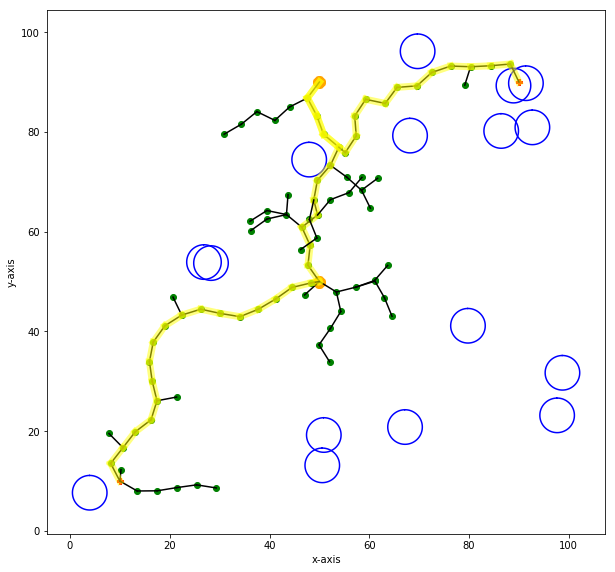

In [7]:
def main():
    max_iter = 500
    epsilon = 4 # step size

    # initial and goal configurations
    x0 = 10
    y0 = 10
    x_goal = 90
    y_goal = 90
    plt.figure(figsize=[10,10])
    plt.scatter([x0,x_goal],[y0,y_goal],c='r',marker="P")
    
    # obstacle info
    noo = 16 # no. of obstacles
    radius = np.sqrt(3)/2*epsilon
    obs_radii = radius*np.ones(noo)
    obs_coors = 100*np.random.rand(2,noo) # position of obstacles
    for i in range(0,noo):
        draw_circle(obs_coors[0,i],obs_coors[1,i],obs_radii[i])
        

    # adding new roots
    via_roots = np.array([[50,50],[50,90]])
    plt.scatter(via_roots[0,:],via_roots[1,:],c='orange',marker="P",linewidth=7)
    noer = via_roots.shape[1] # no. of extra roots
    nt = noer+2
    flag = np.zeros(noer+1) # for finding a connectivity path
    vertices = np.zeros([nt,2,max_iter//nt+1])
    A = -np.ones([nt,max_iter//nt+1,max_iter//nt+1])
    vertices[0,0,0] = x0
    vertices[0,1,0] = y0
    vertices[-1,0,0] = x_goal
    vertices[-1,1,0] = y_goal
    for i in range(0,nt):
        A[i,0,0] = 0
    for i in range(0,noer):
        vertices[i+1,:,0] = via_roots[:,i]
    nov = np.zeros(nt,dtype=np.int64) # no. of vertices except the initial one

    i = 0
    while all(flag)!=1 and i<max_iter:
        i += 1
        k = np.remainder(i-1,nt) # index of the active tree
        if (k==0 and flag[0]!=1) or (0<k<nt-1 and (flag[k-1]!=1 or flag[k]!=1)) or (k==nt-1 and flag[-1]!=1): 
            x_rand= 100*np.random.rand(1)
            y_rand= 100*np.random.rand(1)
            [min_dis,p_near] = nearest_neighbor_2d(x_rand,y_rand,vertices[k,:,:],nov[k]+1)
            if min_dis<epsilon:
                x_new = x_rand
                y_new = y_rand
            else: # interpolate
                r = epsilon/min_dis # ratio
                x_new = vertices[k,0,p_near]+r*(x_rand-vertices[k,0,p_near])
                y_new = vertices[k,1,p_near]+r*(y_rand-vertices[k,1,p_near])
            if collision_check(x_new,y_new,obs_coors,obs_radii):
                nov[k] = nov[k]+1
                vertices[k,0,nov[k]] = x_new
                vertices[k,1,nov[k]] = y_new
                plt.scatter(x_new,y_new,c='g')
                plt.plot([vertices[k,0,p_near],x_new],[vertices[k,1,p_near],y_new],c='black')
                A[k,nov[k],:] = A[k,p_near,:]
                A[k,nov[k],nov[k]] = nov[k]
                if k==0:
                    [min_dis_nextT, p_nextT] = nearest_neighbor_2d(x_new,y_new,vertices[k+1,:,:],nov[k+1]+1)
                    if min_dis_nextT<epsilon:
                        flag[0] = 1
                        plt.plot([x_new,vertices[k+1,0,p_nextT]],[y_new,vertices[k+1,1,p_nextT]],c='black')
                        plt.plot([x_new,vertices[k+1,0,p_nextT]],[y_new,vertices[k+1,1,p_nextT]],c='yellow',linewidth=7,alpha=0.5)
                        plot_path(A,vertices,nov,k,k+1,p_nextT)
                elif 0<k<nt-1:
                    if flag[k-1]==0:
                        [min_dis_prevT, p_prevT] = nearest_neighbor_2d(x_new,y_new,vertices[k-1,:,:],nov[k-1]+1)
                        if min_dis_prevT<epsilon:
                            flag[k-1]=1
                            plt.plot([x_new,vertices[k-1,0,p_prevT]],[y_new,vertices[k-1,1,p_prevT]],c='black')
                            plt.plot([x_new,vertices[k-1,0,p_prevT]],[y_new,vertices[k-1,1,p_prevT]],c='yellow',linewidth=7,alpha=0.5)
                            plot_path(A,vertices,nov,k,k-1,p_prevT)
                    if flag[k]==0:
                        [min_dis_nextT, p_nextT] = nearest_neighbor_2d(x_new,y_new,vertices[k+1,:,:],nov[k+1]+1)
                        if min_dis_nextT<epsilon:
                            flag[k] = 1
                            plt.plot([x_new,vertices[k+1,0,p_nextT]],[y_new,vertices[k+1,1,p_nextT]],c='black')
                            plt.plot([x_new,vertices[k+1,0,p_nextT]],[y_new,vertices[k+1,1,p_nextT]],c='yellow',linewidth=7,alpha=0.5)
                            plot_path(A,vertices,nov,k,k+1,p_nextT)
                else: # elif k==nt-1:
                    [min_dis_prevT, p_prevT] = nearest_neighbor_2d(x_new,y_new,vertices[k-1,:,:],nov[k-1]+1)
                    if min_dis_prevT<epsilon:
                        flag[-1] = 1
                        plt.plot([x_new,vertices[k-1,0,p_prevT]],[y_new,vertices[k-1,1,p_prevT]],c='black')
                        plt.plot([x_new,vertices[k-1,0,p_prevT]],[y_new,vertices[k-1,1,p_prevT]],c='yellow',linewidth=7,alpha=0.5)
                        plot_path(A,vertices,nov,k,k-1,p_prevT)
       
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.axis('scaled')
    plt.savefig('the_basic1.png')
    if all(flag)!=1:
        print('No solution has been found for the given maximum number of iterations.')
for iter in tqdm(range(1)):
    main()